# Plot Example Signals from CA3-CA1 LFP Data

This notebook demonstrates how to load and visualize example signals from hippocampal LFP recordings during sharp wave-ripple events. The data used in this example is from the CRCNS HC-3 dataset (https://crcns.org/data-sets/hc/hc-3/about-hc-3).

**Goal:** This notebook loads raw CA3 and CA1 LFP signals, applies bandpass filtering, and plots example waveforms to visualize the data before causal analysis. This is a preliminary step to understand the signal characteristics before running the full causal analysis pipeline.


In [ ]:
# Set up data directory path
# The data files should be in the 'event_rdcs' directory relative to this notebook
import os

event_rdcs_dir = "event_rdcs"

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy.signal import firwin, lfilter
from trancit.utils.signal import find_peak_locations

## Load LFP Data

Load the CA3 and CA1 LFP recordings from the .mat files. The data files should be named as `{sess_name}_CA3.mat` and `{sess_name}_CA1.mat` in the `event_rdcs` directory.


In [ ]:
# Session name for the data files
sess_name = ""

# Load CA3 LFP data
ca3_mat_path = os.path.join(event_rdcs_dir, f"{sess_name}_CA3.mat")
ca3_data = sio.loadmat(ca3_mat_path)
ca3_lfp = ca3_data["CA3_lfp"]
print(f"CA3 data keys: {ca3_data.keys()}")
print(f"CA3 LFP shape: {ca3_lfp.shape}")

# Load CA1 LFP data
ca1_mat_path = os.path.join(event_rdcs_dir, f"{sess_name}_CA1.mat")
ca1_data = sio.loadmat(ca1_mat_path)
ca1_lfp = ca1_data["CA1_lfp"]
print(f"CA1 data keys: {ca1_data.keys()}")
print(f"CA1 LFP shape: {ca1_lfp.shape}")

dict_keys(['__header__', '__version__', '__globals__', 'CA3_lfp', 'fs'])
(6189372, 32)
dict_keys(['__header__', '__version__', '__globals__', 'CA1_lfp', 'fs'])
(6189372, 32)


## Signal Preprocessing

Select specific channels from CA3 and CA1, and apply bandpass filtering to extract the ripple frequency band (140-230 Hz). This filtering step is essential for isolating sharp wave-ripple events.


## Event Detection

Detect sharp wave-ripple events by applying a threshold to the filtered CA3 signal. Events are identified as peaks that exceed a threshold (mean + 5 standard deviations) and are separated by at least 400 samples.


In [5]:
ca3_channel = 1 
ca1_channel = 0

L_signal = ca1_lfp.shape[0]

y = np.zeros((2, L_signal))
y[0, :] = ca3_lfp[:L_signal, ca3_channel]
y[1, :] = ca1_lfp[:L_signal, ca1_channel]

params = {}
params['Fs'] = 1252
params['passband'] = [140, 230] 

numtaps = 50               # order + 1
B = firwin(
    numtaps,               # number of filter coefficients
    params['passband'],    # cut-off pair
    pass_zero=False,       # 'bandpass' in MATLAB
    window='hamming',      # MATLAB fir1 default
    fs=params['Fs'] * 1.0  # specify design in Hz
)

yf = lfilter(B, 1.0, y.squeeze(), axis=-1)
# yf = lfilter(B, 1, y.T).T
delay = (numtaps - 1) // 2 # same 24-sample group delay
yf = yf[..., delay:]

In [6]:
threshold = np.mean(yf[0, :]) + 5 * np.std(yf[0, :])
temp_loc = np.where(yf[0, :] >= threshold)[0]
local = find_peak_locations(yf[0, :], temp_loc, 400)
local = local[local >= 1500]

## Visualize Example Events

Select specific event indices and plot the corresponding signal segments to visualize the sharp wave-ripple waveforms in both CA3 and CA1 channels.


In [7]:
local[45]

642352

In [8]:
local[63]

925518

In [9]:
loc = np.array([1035, 1860 + 75]) - 300

L = 200
t_range_event1 = np.arange(loc[0] - 99, loc[0] + 101)
t_range_event2 = np.arange(loc[1] - 99, loc[1] + 101)

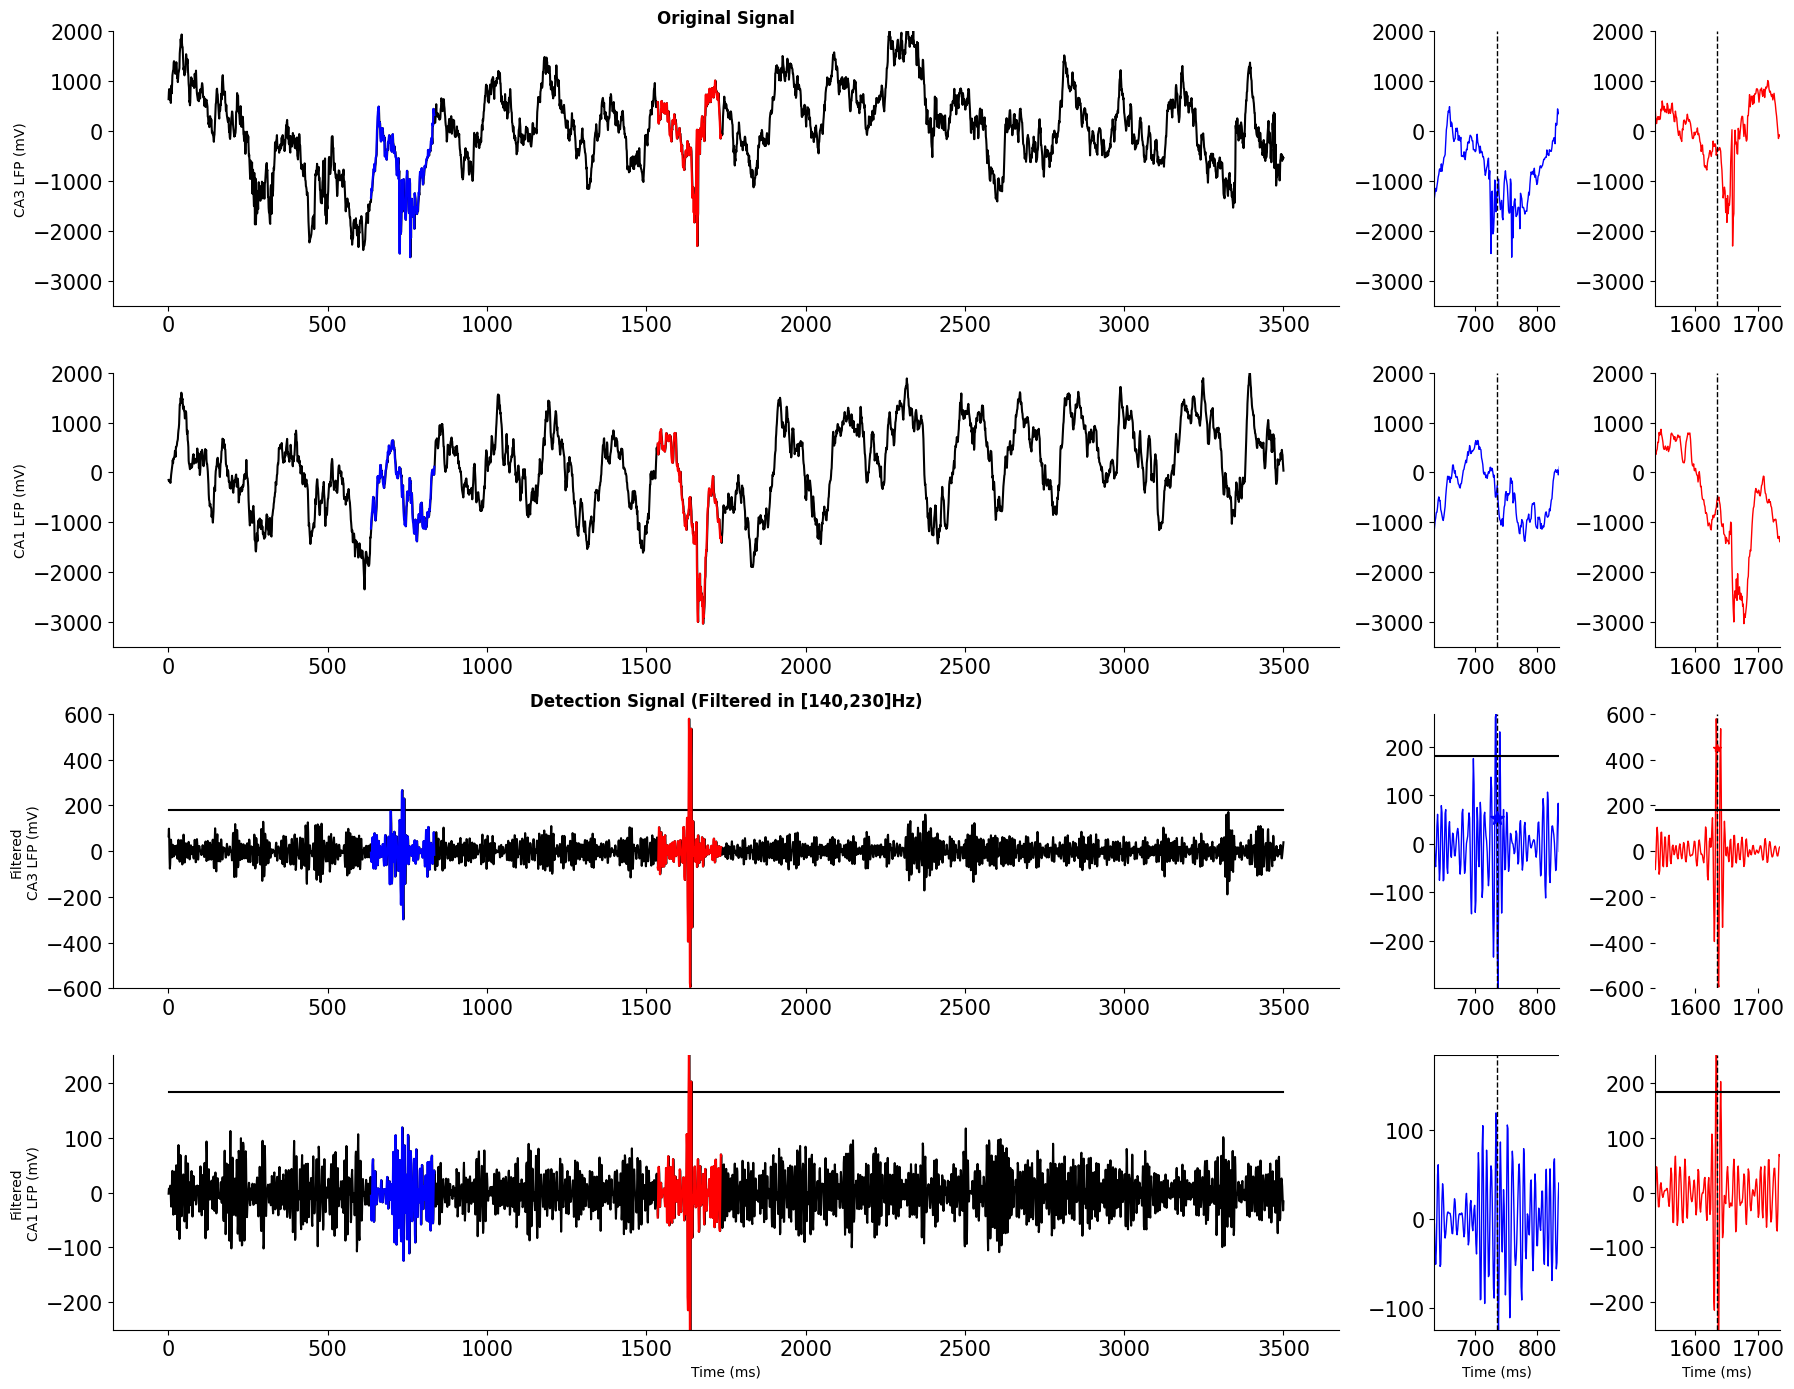

In [10]:
i = 45
L  = 3500
Fs = 1

t_range = local[i] - 1035 + 300 + np.arange(1, L + 1)
y_short  = y[:,  t_range-24]
yf_short = yf[:, t_range]

fig = plt.figure(figsize=(18, 14))
gs  = fig.add_gridspec(4, 8)

ax1 = fig.add_subplot(gs[0, 0:6])
ax1.plot(np.arange(1, L + 1) / (Fs * Fs), y_short[0, :], 'k')
ax1.set_ylim(-3500, 2000)
ax1.plot(t_range_event1 / Fs, y_short[0, t_range_event1], 'b')
ax1.plot(t_range_event2 / Fs, y_short[0, t_range_event2], 'r')
ax1.set_ylabel('CA3 LFP (mV)')
ax1.set_title('Original Signal', fontweight='bold')
# ax1.set_frame_on(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.tick_params(labelsize=15)

ax2 = fig.add_subplot(gs[1, 0:6])      # same as subplot(4,8,[1:6] + 8)
ax2.plot(np.arange(1, L + 1) / Fs, y_short[1, :], 'k')
ax2.set_ylim(-3500, 2000)
ax2.plot(t_range_event1 / Fs, y_short[1, t_range_event1], 'b')
ax2.plot(t_range_event2 / Fs, y_short[1, t_range_event2], 'r')
ax2.set_ylabel('CA1 LFP (mV)')
# ax2.set_frame_on(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.tick_params(labelsize=15)

ax3 = fig.add_subplot(gs[2, 0:6])
ax3.plot(np.arange(1, L + 1) / Fs, yf_short[0, :], 'k')
ax3.set_ylim(-600, 600)
threshold1 = np.mean(yf[0, :]) + 5 * np.std(yf[0, :])
ax3.plot(np.array([1, L]) / Fs, [threshold1, threshold1], 'k')
ax3.plot(t_range_event1 / Fs, yf_short[0, t_range_event1], 'b')
ax3.plot(t_range_event2 / Fs, yf_short[0, t_range_event2], 'r')
ax3.set_ylabel('Filtered\nCA3 LFP (mV)')  # \n for multi-line label
ax3.set_title('Detection Signal (Filtered in [140,230]Hz)', fontweight='bold')
# ax3.set_frame_on(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.tick_params(labelsize=15)

ax4 = fig.add_subplot(gs[3, 0:6])
ax4.plot(np.arange(1, L + 1) / Fs, yf_short[1, :], 'k')
ax4.set_ylim(-250, 250)
threshold2 = np.mean(yf[1, :]) + 5 * np.std(yf[1, :])
ax4.plot(np.array([1, L]) / Fs, [threshold2, threshold2], 'k')
ax4.plot(t_range_event1 / Fs, yf_short[1, t_range_event1], 'b')
ax4.plot(t_range_event2 / Fs, yf_short[1, t_range_event2], 'r')
ax4.set_ylabel('Filtered\nCA1 LFP (mV)')
ax4.set_xlabel('Time (ms)')
# ax4.set_frame_on(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.tick_params(labelsize=15)


# Side Figure (Narrow): Event 1
ylim_wide1 = ax1.get_ylim()
ylim_wide2 = ax2.get_ylim()
ylim_wide3 = ax3.get_ylim()
ylim_wide4 = ax4.get_ylim()

ax_narrow1 = fig.add_subplot(gs[0, 6])
ax_narrow1.plot(t_range_event1 / Fs, y_short[0, t_range_event1], 'b', linewidth=1)
ax_narrow1.axvline(loc[0] / Fs, color='k', linestyle='--', linewidth=1)  # Vertical line at event
ax_narrow1.set_xlim([t_range_event1[0] / Fs, t_range_event1[-1] / Fs])
ax_narrow1.set_ylim(ylim_wide1)  # Match y-limits with wide plot
# ax_narrow1.set_title('Detected Events')
# ax_narrow1.set_frame_on(False)
ax_narrow1.spines['top'].set_visible(False)
ax_narrow1.spines['right'].set_visible(False)
ax_narrow1.yaxis.set_ticks_position('left')
ax_narrow1.xaxis.set_ticks_position('bottom')
ax_narrow1.tick_params(labelsize=15)  # Font size for ticks

ax_narrow2 = fig.add_subplot(gs[1, 6])
ax_narrow2.plot(t_range_event1 / Fs, y_short[1, t_range_event1], 'b', linewidth=1)
ax_narrow2.axvline(loc[0] / Fs, color='k', linestyle='--', linewidth=1)
ax_narrow2.set_xlim([t_range_event1[0] / Fs, t_range_event1[-1] / Fs])
ax_narrow2.set_ylim(ylim_wide2)
# ax_narrow2.set_frame_on(False)
ax_narrow2.spines['top'].set_visible(False)
ax_narrow2.spines['right'].set_visible(False)
ax_narrow2.yaxis.set_ticks_position('left')
ax_narrow2.xaxis.set_ticks_position('bottom')
ax_narrow2.tick_params(labelsize=15)

ax_narrow3 = fig.add_subplot(gs[2, 6])
ax_narrow3.plot(t_range_event1 / Fs, yf_short[0, t_range_event1], 'b', linewidth=1)
mean_yf1 = np.mean(yf[0, :])
std_yf1 = np.std(yf[0, :])
threshold1 = mean_yf1 + 5 * std_yf1
ax_narrow3.axhline(threshold1, color='k')
ax_narrow3.axvline(loc[0] / Fs, color='k', linestyle='--', linewidth=1)
ax_narrow3.plot(loc[0] / Fs, yf_short[0, loc[0]], 'b*', markersize=10)
ax_narrow3.set_xlim([t_range_event1[0] / Fs, t_range_event1[-1] / Fs])
# Adjust y-limits to include signal and threshold
ylim_narrow3 = [min(np.min(yf_short[0, t_range_event1]), threshold1), 
                max(np.max(yf_short[0, t_range_event1]), threshold1)]
ax_narrow3.set_ylim(ylim_narrow3)
# ax_narrow3.set_frame_on(False)
ax_narrow3.spines['top'].set_visible(False)
ax_narrow3.spines['right'].set_visible(False)
ax_narrow3.yaxis.set_ticks_position('left')
ax_narrow3.xaxis.set_ticks_position('bottom')
ax_narrow3.tick_params(labelsize=15)

ax_narrow4 = fig.add_subplot(gs[3, 6])
ax_narrow4.plot(t_range_event1 / Fs, yf_short[1, t_range_event1], 'b', linewidth=1)
mean_yf2 = np.mean(yf[1, :])
std_yf2 = np.std(yf[1, :])
threshold2 = mean_yf2 + 5 * std_yf2
ax_narrow4.axhline(threshold2, color='k')
ax_narrow4.axvline(loc[0] / Fs, color='k', linestyle='--', linewidth=1)
ax_narrow4.set_xlim([t_range_event1[0] / Fs, t_range_event1[-1] / Fs])
# Adjust y-limits to include signal and threshold
ylim_narrow4 = [min(np.min(yf_short[1, t_range_event1]), threshold2), 
                max(np.max(yf_short[1, t_range_event1]), threshold2)]
ax_narrow4.set_ylim(ylim_narrow4)
ax_narrow4.set_xlabel('Time (ms)')
# ax_narrow4.set_frame_on(False)
ax_narrow4.spines['top'].set_visible(False)
ax_narrow4.spines['right'].set_visible(False)
ax_narrow4.yaxis.set_ticks_position('left')
ax_narrow4.xaxis.set_ticks_position('bottom')
ax_narrow4.tick_params(labelsize=15)

# --------------------------------------------------------------------------------------------------------
# Side Figure (Narrow): Event 2
ax_narrow5 = fig.add_subplot(gs[0, 7])
ax_narrow5.plot(t_range_event2 / Fs, y_short[0, t_range_event2], 'r', linewidth=1)
ax_narrow5.axvline(loc[1] / Fs, color='k', linestyle='--', linewidth=1)
ax_narrow5.set_xlim([t_range_event2[0] / Fs, t_range_event2[-1] / Fs])
ax_narrow5.set_ylim(ylim_wide1)
# ax_narrow5.set_frame_on(False)
ax_narrow5.spines['top'].set_visible(False)
ax_narrow5.spines['right'].set_visible(False)
ax_narrow5.yaxis.set_ticks_position('left')
ax_narrow5.xaxis.set_ticks_position('bottom')
ax_narrow5.tick_params(labelsize=15)  # Font size for ticks

ax_narrow6 = fig.add_subplot(gs[1, 7])
ax_narrow6.plot(t_range_event2 / Fs, y_short[1, t_range_event2], 'r', linewidth=1)
ax_narrow6.axvline(loc[1] / Fs, color='k', linestyle='--', linewidth=1)
ax_narrow6.set_xlim([t_range_event2[0] / Fs, t_range_event2[-1] / Fs])
ax_narrow6.set_ylim(ylim_wide2)
# ax_narrow6.set_frame_on(False)
ax_narrow6.spines['top'].set_visible(False)
ax_narrow6.spines['right'].set_visible(False)
ax_narrow6.yaxis.set_ticks_position('left')
ax_narrow6.xaxis.set_ticks_position('bottom')
ax_narrow6.tick_params(labelsize=15)

ax_narrow7 = fig.add_subplot(gs[2, 7])
ax_narrow7.plot(t_range_event2 / Fs, yf_short[0, t_range_event2], 'r', linewidth=1)
mean_yf1 = np.mean(yf[0, :])
std_yf1 = np.std(yf[0, :])
threshold1 = mean_yf1 + 5 * std_yf1
ax_narrow7.axhline(threshold1, color='k')
ax_narrow7.axvline(loc[1] / Fs, color='k', linestyle='--', linewidth=1)
locs = [loc[1]]
ax_narrow7.plot(np.array(locs) / Fs, yf_short[0, locs], 'r*', linewidth=2)
ax_narrow7.set_xlim([t_range_event2[0] / Fs, t_range_event2[-1] / Fs])
ax_narrow7.set_ylim(ylim_wide3)
ax_narrow7.set_frame_on(False)
# ax_narrow7.set_frame_on(False)
ax_narrow7.spines['top'].set_visible(False)
ax_narrow7.spines['right'].set_visible(False)
ax_narrow7.yaxis.set_ticks_position('left')
ax_narrow7.xaxis.set_ticks_position('bottom')
ax_narrow7.tick_params(labelsize=15)

ax_narrow8 = fig.add_subplot(gs[3, 7])
ax_narrow8.plot(t_range_event2 / Fs, yf_short[1, t_range_event2], 'r', linewidth=1)
mean_yf2 = np.mean(yf[1, :])
std_yf2 = np.std(yf[1, :])
threshold2 = mean_yf2 + 5 * std_yf2
ax_narrow8.axhline(threshold2, color='k')
ax_narrow8.axvline(loc[1] / Fs, color='k', linestyle='--', linewidth=1)
ax_narrow8.set_xlim([t_range_event2[0] / Fs, t_range_event2[-1] / Fs])
ax_narrow8.set_ylim(ylim_wide4)
ax_narrow8.set_xlabel('Time (ms)')
# ax_narrow8.set_frame_on(False)
ax_narrow8.spines['top'].set_visible(False)
ax_narrow8.spines['right'].set_visible(False)
ax_narrow8.yaxis.set_ticks_position('left')
ax_narrow8.xaxis.set_ticks_position('bottom')
ax_narrow8.tick_params(labelsize=15)

plt.tight_layout()

figure_name = "events_waveforms_plot"
plt.savefig(f"{figure_name}.svg", format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f"{figure_name}.eps", format='eps', bbox_inches='tight')